# Filter Dataset

In [1]:
import json
from sahi.utils.coco import Coco, CocoAnnotation, CocoCategory, CocoImage
from sahi.utils.file import load_json, save_json

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import copy
import os
import shutil
from pathlib import Path
def copy_files_to_directory(file_paths, new_directory):
    # Create the new directory if it doesn't exist
    Path(new_directory).mkdir(parents=True, exist_ok=True)

    # Copy each file into the new directory
    for file_path in file_paths:
        file_name = Path(file_path).name
        destination = Path(new_directory) / file_name
        shutil.copyfile(file_path, str(destination))
        
def update_categories(coco,desired_name2id, update_image_filenames=False):
        """
        Rearranges category mapping of given COCO object based on given desired_name2id.
        Can also be used to filter some of the categories.

        Args:
            desired_name2id: dict
                {"big_vehicle": 1, "car": 2, "human": 3}
            update_image_filenames: bool
                If True, updates coco image file_names with absolute file paths.
        """
        # init vars
        currentid2desiredid_mapping = {}
        updated_coco = Coco(
            name=coco.name,
            image_dir=coco.image_dir,
            remapping_dict=coco.remapping_dict,
            ignore_negative_samples=coco.ignore_negative_samples,
        )
        # create category id mapping (currentid2desiredid_mapping)
        for coco_category in copy.deepcopy(coco.categories):
            current_category_id = coco_category.id
            current_category_name = coco_category.name
            if current_category_name in desired_name2id.keys():
                currentid2desiredid_mapping[current_category_id] = desired_name2id[current_category_name]
            else:
                # ignore categories that are not included in desired_name2id
                currentid2desiredid_mapping[current_category_id] = None

        # add updated categories
        for name in desired_name2id.keys():
            updated_coco_category = CocoCategory(id=desired_name2id[name], name=name, supercategory=name)
            updated_coco.add_category(updated_coco_category)

        # add updated images & annotations
        for coco_image in copy.deepcopy(coco.images):
            updated_coco_image = CocoImage.from_coco_image_dict(coco_image.json)
            # update filename to abspath
            file_name_is_abspath = True if os.path.abspath(coco_image.file_name) == coco_image.file_name else False
            if update_image_filenames and not file_name_is_abspath:
                updated_coco_image.file_name = str(Path(os.path.abspath(self.image_dir)) / coco_image.file_name)
            # update annotations
            for coco_annotation in coco_image.annotations:
                # print(coco_annotation)
                current_category_id = coco_annotation.category_id
                desired_category_id = currentid2desiredid_mapping[current_category_id]
                # append annotations with category id present in desired_name2id
                if desired_category_id is not None:
                    # update cetegory id
                    coco_annotation.category_id = desired_category_id
                    # append updated annotation to target coco dict
                    updated_coco_image.add_annotation(coco_annotation)
            updated_coco.add_image(updated_coco_image)

        # overwrite instance
        coco.__class__ = updated_coco.__class__
        coco.__dict__ = updated_coco.__dict__

def update_categories_small(coco,desired_name2id, update_image_filenames=False):
        # train
        # l_im = [4098, 4099, 2057, 4106, 2060, 2061, 4109, 2063, 2064, 2066, 2067, 2068, 2069, 2070, 14365, 14366, 14367, 14368, 14369, 14371, 14372, 14373, 14374, 14375, 14376, 14379, 14380, 14381, 57, 58, 61, 62, 69, 70, 91, 2163, 2164, 2165, 2166, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2178, 2179, 10381, 143, 2191, 145, 2192, 2193, 149, 2197, 2198, 2199, 8353, 8354, 8355, 8356, 8358, 8359, 8360, 8361, 8362, 10440, 10441, 10442, 10445, 10447, 10448, 10450, 10451, 10453, 10454, 6359, 6360, 6366, 6367, 14561, 14562, 6373, 6374, 4339, 4340, 4345, 4346, 6402, 6403, 6404, 6405, 6406, 6407, 6408, 6409, 6410, 14606, 14607, 4375, 4376, 4382, 4383, 11862, 8622, 476, 477, 12775, 12776, 489, 14828, 14829, 12782, 12783, 14830, 14835, 14836, 14837, 2586, 2587, 12830, 12835, 8740, 8741, 8742, 10792, 8746, 8747, 556, 8748, 8749, 561, 562, 563, 564, 8753, 566, 567, 568, 569, 570, 2616, 572, 573, 574, 575, 2622, 12856, 12857, 12858, 12859, 12860, 12861, 12862, 12863, 12864, 12865, 12866, 12867, 12868, 12869, 12870, 12873, 2641, 2642, 12874, 12875, 12876, 2646, 2647, 2648, 12881, 12882, 12883, 2652, 12884, 12886, 12887, 12888, 12890, 12891, 13963, 13964, 2695, 13969, 2703, 2705, 2706, 4807, 4808, 4809, 4810, 4811, 14927, 2810, 2812, 2813, 2814, 2815, 6928, 6931, 6932, 6936, 6937, 6938, 6939, 13110, 855, 4956, 4957, 4959, 4960, 7010, 7011, 7015, 4970, 7020, 4973, 2926, 2928, 2929, 11159, 11165, 11173, 11174, 11175, 11180, 11181, 11185, 11186, 13246, 3026, 3027, 3028, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3039, 3040, 9220, 9224, 7177, 7178, 8754, 7182, 7183, 7185, 7186, 7187, 1044, 1045, 3094, 1047, 1048, 1049, 1050, 1051, 1052, 3098, 3099, 3102, 3103, 7198, 7201, 7202, 7203, 7204, 7207, 7208, 7209, 7212, 7213, 11313, 11314, 11317, 11318, 8755, 1137, 1138, 1139, 1141, 1143, 1144, 1145, 1147, 7323, 7331, 11427, 12855, 3241, 3242, 7337, 7338, 11433, 11439, 3248, 3249, 11450, 3095, 3295, 3300, 14908, 7433, 7434, 7435, 7438, 7439, 7440, 7441, 5397, 5398, 5399, 7445, 5401, 5402, 7451, 5404, 5405, 12878, 5407, 5408, 12879, 14918, 7188, 7189, 7190, 7191, 14925, 7192, 14926, 1372, 1373, 7193, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 13666, 13667, 1384, 13673, 14928, 1387, 1388, 1389, 9581, 9582, 14930, 9585, 9586, 13687, 13688, 13721, 13722, 13727, 13728, 11683, 11684, 11689, 11690, 11691, 11696, 11697, 11698, 9653, 11283, 11284, 11287, 11288, 3554, 9699, 9700, 9702, 9703, 9759, 9764, 3628, 7747, 7748, 7753, 7754, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 11863, 11867, 11873, 5754, 5755, 5760, 5761, 5762, 7810, 7811, 11904, 5766, 11905, 5768, 11906, 11909, 5771, 5772, 5773, 11910, 11911, 11912, 5777, 1682, 1683, 1684, 1685, 5778, 5779, 13968, 1689, 1690, 13970, 13971, 13972, 13974, 1704, 1706, 9902, 1711, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 11981, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 7906, 7907, 1815, 1816, 10007, 10012, 1821, 1822, 1823, 10013, 1825, 10014, 1827, 1828, 10015, 10016, 10017, 10018, 1833, 10019, 3883, 3884, 10020, 10023, 14138, 14139, 14140, 14143, 14144, 14145, 14146, 14147, 14150, 14151, 14152, 14157, 14164, 8027, 8028, 12124, 14172, 8032, 8033, 8035, 8036, 12131, 8040, 8041, 8042, 8043, 12138, 8050, 8051, 8052, 8053, 8061, 1918, 1919, 1921, 1922, 14223, 14224, 3985, 3986, 14225, 14229, 3990, 3991, 14230, 14234, 3995, 3996, 14235, 14236, 14238, 14239, 14240, 14243, 14244, 10149, 10150, 10151, 14245, 14246, 10154, 10155, 14247, 14249, 14250, 14251, 12212, 12213, 12223, 4035, 10179, 4037, 4038, 12227, 12236, 12237, 12239, 12240, 12241, 12242, 12243, 12244, 12245, 12246, 8178, 8186, 8188, 8189]
        # Val indicies
        l_im = [4098, 4099, 3588, 3589, 4101, 4102, 4103, 4105, 4106, 4108, 525, 4109, 4125, 4129, 42, 43, 2620, 2621, 2625, 2626, 2640, 2644, 3670, 3688, 3689, 3692, 3693, 3694, 3700, 3701, 4094, 1686, 1687, 1688, 1693, 1700, 1701, 3245, 3246, 3251, 3252, 3253, 3256, 3257, 3258, 3259, 3260, 3345, 3262, 3263, 3264, 3266, 2246, 3788, 3789, 3790, 3794, 3795, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 3799, 3807, 1761, 738, 739, 1762, 1763, 3815, 1768, 3816, 237, 238, 2799, 2800, 242, 243, 1784, 248, 249, 250, 1787, 252, 253, 254, 255, 2809, 2810, 260, 261, 1286, 1287, 1288, 1289, 266, 267, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 2830, 2831, 1304, 1305, 2836, 2839, 3349, 3350, 3351, 3352, 3353, 3386, 3392, 3906, 3907, 2372, 3908, 3909, 3910, 2378, 847, 848, 851, 2387, 2388, 854, 855, 2391, 2392, 858, 859, 3429, 3432, 3436, 1389, 1414, 1415, 1416, 1417, 1418, 1422, 1423, 3339, 430, 431, 432, 433, 3343, 437, 438, 3344, 957, 2493, 959, 960, 961, 962, 2494, 2499, 2500, 2501, 967, 3346, 969, 2506, 2507, 2508, 4057, 4058, 4066, 4067, 3580, 3581, 3582]
        """
        Andrew 7.18.2023: only return 32 images (2 batches)
        Rearranges category mapping of given COCO object based on given desired_name2id.
        Can also be used to filter some of the categories.

        Args:
            desired_name2id: dict
                {"big_vehicle": 1, "car": 2, "human": 3}
            update_image_filenames: bool
                If True, updates coco image file_names with absolute file paths.
        """
        # init vars
        currentid2desiredid_mapping = {}
        updated_coco = Coco(
            name=coco.name,
            image_dir=coco.image_dir,
            remapping_dict=coco.remapping_dict,
            ignore_negative_samples=coco.ignore_negative_samples,
        )
        # create category id mapping (currentid2desiredid_mapping)
        for coco_category in copy.deepcopy(coco.categories):
            current_category_id = coco_category.id
            current_category_name = coco_category.name
            if current_category_name in desired_name2id.keys():
                currentid2desiredid_mapping[current_category_id] = desired_name2id[current_category_name]
            else:
                # ignore categories that are not included in desired_name2id
                currentid2desiredid_mapping[current_category_id] = None

        # add updated categories
        for name in desired_name2id.keys():
            updated_coco_category = CocoCategory(id=desired_name2id[name], name=name, supercategory=name)
            updated_coco.add_category(updated_coco_category)
        l = []
        # add updated images & annotations
        for ind,coco_image in enumerate(copy.deepcopy([coco.images[i] for i in l_im[:32]])):
        # for ind,coco_image in enumerate(copy.deepcopy(coco.images)):

            updated_coco_image = CocoImage.from_coco_image_dict(coco_image.json)
            # update filename to abspath
            file_name_is_abspath = True if os.path.abspath(coco_image.file_name) == coco_image.file_name else False
            if update_image_filenames and not file_name_is_abspath:
                updated_coco_image.file_name = str(Path(os.path.abspath(self.image_dir)) / coco_image.file_name)
            # update annotations
            for coco_annotation in coco_image.annotations:
                # print(coco_annotation)
                current_category_id = coco_annotation.category_id
                desired_category_id = currentid2desiredid_mapping[current_category_id]
                # append annotations with category id present in desired_name2id
                if desired_category_id is not None:
                    # print(ind)
                    l.append(ind)
                    # update cetegory id
                    coco_annotation.category_id = desired_category_id
                    # append updated annotation to target coco dict
                    updated_coco_image.add_annotation(coco_annotation)
            updated_coco.add_image(updated_coco_image)
        print(set(l))
        # overwrite instance
        coco.__class__ = updated_coco.__class__
        coco.__dict__ = updated_coco.__dict__

In [4]:
PATH = '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_640_02.json'

coco = Coco.from_coco_dict_or_path(PATH)
print(coco.json_categories)
coco.calculate_stats()
print(coco.stats)
update_categories_small(coco,desired_name2id={'Fixed-wing Aircraft':1,'Cargo Plane':2})
coco.calculate_stats()
from sahi.utils.coco import create_coco_dict
cats = coco.json_categories
di = create_coco_dict(coco.images,coco.categories,ignore_negative_samples=True)
di['categories']=coco.json_categories
JSON_PATH='/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_640_02_filtered_32.json'
json.dump(di,open(JSON_PATH,'w'))
coco_u = Coco.from_coco_dict_or_path(JSON_PATH)
coco_u.calculate_stats()
coco_u.stats
id2fname = {i.id:i.file_name for i in coco_u.images}
fnames = list(id2fname.values())
import os
NEW_DIR = '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg_filt_32/train_images_640_02_filt_32'

full_fnames = [os.path.join('/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_images_640_02',i) for i in fnames]
print(full_fnames)
copy_files_to_directory(full_fnames,NEW_DIR)

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 15154/15154 [00:55<00:00, 271.09it/s]


[{'id': 0, 'name': 'Fixed-wing Aircraft', 'supercategory': 'Fixed-wing Aircraft'}, {'id': 1, 'name': 'Small Aircraft', 'supercategory': 'Small Aircraft'}, {'id': 2, 'name': 'Cargo Plane', 'supercategory': 'Cargo Plane'}, {'id': 3, 'name': 'Helicopter', 'supercategory': 'Helicopter'}, {'id': 4, 'name': 'Passenger Vehicle', 'supercategory': 'Passenger Vehicle'}, {'id': 5, 'name': 'Small Car', 'supercategory': 'Small Car'}, {'id': 6, 'name': 'Bus', 'supercategory': 'Bus'}, {'id': 7, 'name': 'Pickup Truck', 'supercategory': 'Pickup Truck'}, {'id': 8, 'name': 'Utility Truck', 'supercategory': 'Utility Truck'}, {'id': 9, 'name': 'Truck', 'supercategory': 'Truck'}, {'id': 10, 'name': 'Cargo Truck', 'supercategory': 'Cargo Truck'}, {'id': 11, 'name': 'Truck w/Box', 'supercategory': 'Truck w/Box'}, {'id': 12, 'name': 'Truck Tractor', 'supercategory': 'Truck Tractor'}, {'id': 13, 'name': 'Trailer', 'supercategory': 'Trailer'}, {'id': 14, 'name': 'Truck w/Flatbed', 'supercategory': 'Truck w/Flatb

Loading coco annotations: 100%|██████████| 5/5 [00:00<00:00, 6762.82it/s]

['/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_images_640_02/1165_0_2048_640_2688.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_images_640_02/1165_0_2251_640_2891.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_images_640_02/2498_512_512_1152_1152.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_images_640_02/2498_512_1024_1152_1664.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_images_640_02/2531_2048_512_2688_1152.jpg']


In [5]:
PATH = '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_640_02.json'

coco = Coco.from_coco_dict_or_path(PATH)
print(coco.json_categories)
coco.calculate_stats()
print(coco.stats)
update_categories_small(coco,desired_name2id={'Fixed-wing Aircraft':1,'Cargo Plane':2})
coco.calculate_stats()
from sahi.utils.coco import create_coco_dict
cats = coco.json_categories
di = create_coco_dict(coco.images,coco.categories,ignore_negative_samples=True)
di['categories']=coco.json_categories
JSON_PATH='/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_640_02_filtered_32.json'
json.dump(di,open(JSON_PATH,'w'))
coco_u = Coco.from_coco_dict_or_path(JSON_PATH)
# create new folder that only has the images in the training set
id2fname = {i.id:i.file_name for i in coco_u.images}
fnames = list(id2fname.values())
import os
NEW_DIR = '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg_filt_32/val_images_640_02_filt_32'

full_fnames = [os.path.join('/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_images_640_02',i) for i in fnames]
print(full_fnames)
copy_files_to_directory(full_fnames,NEW_DIR)

indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 4419/4419 [00:15<00:00, 285.54it/s]


[{'id': 0, 'name': 'Fixed-wing Aircraft', 'supercategory': 'Fixed-wing Aircraft'}, {'id': 1, 'name': 'Small Aircraft', 'supercategory': 'Small Aircraft'}, {'id': 2, 'name': 'Cargo Plane', 'supercategory': 'Cargo Plane'}, {'id': 3, 'name': 'Helicopter', 'supercategory': 'Helicopter'}, {'id': 4, 'name': 'Passenger Vehicle', 'supercategory': 'Passenger Vehicle'}, {'id': 5, 'name': 'Small Car', 'supercategory': 'Small Car'}, {'id': 6, 'name': 'Bus', 'supercategory': 'Bus'}, {'id': 7, 'name': 'Pickup Truck', 'supercategory': 'Pickup Truck'}, {'id': 8, 'name': 'Utility Truck', 'supercategory': 'Utility Truck'}, {'id': 9, 'name': 'Truck', 'supercategory': 'Truck'}, {'id': 10, 'name': 'Cargo Truck', 'supercategory': 'Cargo Truck'}, {'id': 11, 'name': 'Truck w/Box', 'supercategory': 'Truck w/Box'}, {'id': 12, 'name': 'Truck Tractor', 'supercategory': 'Truck Tractor'}, {'id': 13, 'name': 'Trailer', 'supercategory': 'Trailer'}, {'id': 14, 'name': 'Truck w/Flatbed', 'supercategory': 'Truck w/Flatb

Loading coco annotations: 100%|██████████| 32/32 [00:00<00:00, 5699.99it/s]

['/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_images_640_02/2518_1024_1024_1664_1664.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_images_640_02/2518_1536_1024_2176_1664.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_images_640_02/548_512_512_1152_1152.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_images_640_02/548_1024_512_1664_1152.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_images_640_02/2518_1024_1536_1664_2176.jpg', '/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg/val_images_640_02/2518_1536_1536_2176_2176.jp

In [99]:
!ls /run/determined/workdir/shared_fs/01\ -\ Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_images_640_02/ | wc -l

26007


In [122]:

# copy_files_to_directory(full_fnames,NEW_DIR)

In [43]:
coco.calculate_stats()
coco.stats

In [8]:
image_ids = [i.id for i in coco_u.images]
# ids = list(image_ids.keys())
id_2_coco = {i.id:i for i in coco_u.images}
len(image_ids)

32

In [13]:
IDX = 10
id_2_coco[image_ids[IDX]]

CocoImage<
    id: 11,
    file_name: 2524_0_0_640_640.jpg,
    height: 640,
    width: 640,
    annotations: List[CocoAnnotation],
    predictions: List[CocoPrediction]>

CocoAnnotation<
    image_id: None,
    bbox: [263.0, 189.0, 56.0, 46.0],
    segmentation: [[263, 189, 263, 235, 319, 235, 319, 189]],
    category_id: 2,
    category_name: Cargo Plane,
    iscrowd: 0,
    area: 2576>
CocoAnnotation<
    image_id: None,
    bbox: [295.0, 80.0, 55.0, 45.0],
    segmentation: [[295, 80, 295, 125, 350, 125, 350, 80]],
    category_id: 2,
    category_name: Cargo Plane,
    iscrowd: 0,
    area: 2475>
CocoAnnotation<
    image_id: None,
    bbox: [92.0, 2.0, 73.0, 48.0],
    segmentation: [[92, 2, 92, 50, 165, 50, 165, 2]],
    category_id: 2,
    category_name: Cargo Plane,
    iscrowd: 0,
    area: 3504>
CocoAnnotation<
    image_id: None,
    bbox: [438.0, 180.0, 64.0, 52.0],
    segmentation: [[438, 180, 438, 232, 502, 232, 502, 180]],
    category_id: 2,
    category_name: Cargo Plane,
    iscrowd: 0,
    area: 3328>
CocoAnnotation<
    image_id: None,
    bbox: [419.0, 268.0, 61.0, 53.0],
    segmentation: [[419, 268, 419, 321, 480, 321, 480, 268]]

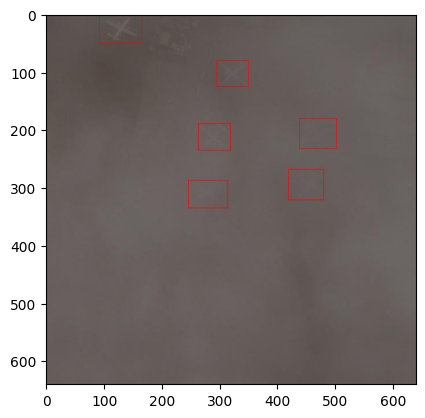

In [12]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
IDX = 10
im = Image.open('/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/val_images_rgb_no_neg_filt_32/val_images_640_02_filt_32/' + id_2_coco[image_ids[IDX]].file_name)
draw = ImageDraw.Draw(im)
for a in id_2_coco[image_ids[IDX]].annotations:
    # print(a)
    # if a.category_id ==0 or a.category_id ==2:
    x,y,w,h = a.bbox
    print(a)
    draw.rectangle([x,y,x+w,y+h],None,(255,0,0),1)
plt.imshow(im)
plt.show()

In [131]:
# save_json(coco.json,'xview_dataset/train_images_rgb_no_neg/train_640_02_filtered_negatives.json')

In [138]:
# from typing import Dict, List, Optional, Set, Union
# def remove_invalid_coco_results2(result_list_or_path: Union[List, str], dataset_dict_or_path: Union[Dict, str] = None):
#     """
#     Removes invalid predictions from coco result such as:
#         - negative bbox value
#         - extreme bbox value

#     Args:
#         result_list_or_path: path or list for coco result json
#         dataset_dict_or_path (optional): path or dict for coco dataset json
#     """

#     # prepare coco results
#     if isinstance(result_list_or_path, str):
#         result_list = [load_json(result_list_or_path)]
#     elif isinstance(result_list_or_path, list):
#         result_list = result_list_or_path
#     else:
#         raise TypeError('incorrect type for "result_list_or_path"')

#     # prepare image info from coco dataset
#     if dataset_dict_or_path is not None:
#         if isinstance(dataset_dict_or_path, str):
#             dataset_dict = load_json(dataset_dict_or_path)
#         elif isinstance(dataset_dict_or_path, dict):
#             dataset_dict = dataset_dict_or_path
#         else:
#             raise TypeError('incorrect type for "dataset_dict"')
#         image_id_to_height = {}
#         image_id_to_width = {}
#         for coco_image in dataset_dict["images"]:
#             image_id_to_height[coco_image["id"]] = coco_image["height"]
#             image_id_to_width[coco_image["id"]] = coco_image["width"]

#     # remove invalid predictions
#     fixed_result_list = []
#     for coco_result in result_list:
#         bbox = coco_result["bbox"]
#         # ignore invalid predictions
#         if not bbox:
#             print("ignoring invalid prediction with empty bbox")
#             continue
#         if bbox[0] < 0 or bbox[1] < 0 or bbox[2] < 0 or bbox[3] < 0:
#             print(f"ignoring invalid prediction with bbox: {bbox}")
#             continue
#         if dataset_dict_or_path is not None:
#             if (
#                 bbox[1] > image_id_to_height[coco_result["image_id"]]
#                 or bbox[3] > image_id_to_height[coco_result["image_id"]]
#                 or bbox[0] > image_id_to_width[coco_result["image_id"]]
#                 or bbox[2] > image_id_to_width[coco_result["image_id"]]
#             ):
#                 print(f"ignoring invalid prediction with bbox: {bbox}")
#                 continue
#         fixed_result_list.append(coco_result)
#     return fixed_result_list

In [44]:
# # from sahi.utils.coco import remove_invalid_coco_results

# # remove invalid predictions from COCO results JSON
# coco_results = remove_invalid_coco_results2("xview_dataset/train_images_rgb_no_neg/train_640_02_filtered_negatives.json")

# # export processed COCO results
# save_json(coco_results.json, "xview_dataset/train_images_rgb_no_neg/train_640_02_filtered.json")

# # bonus: remove invalid predictions from COCO results JSON by giving COCO
# # dataset path to also filter out bbox results exceeding image height&width
# # coco_results = remove_invalid_coco_results("coco_result.json", "coco_dataset.json")

In [2]:
import json
from sahi.utils.coco import Coco, CocoAnnotation, CocoCategory, CocoImage
from sahi.utils.file import load_json, save_json
from sahi.utils.coco import create_coco_dict
import copy
import os

def update_categories(coco,desired_name2id, update_image_filenames=False):
        """
        Rearranges category mapping of given COCO object based on given desired_name2id.
        Can also be used to filter some of the categories.

        Args:
            desired_name2id: dict
                {"big_vehicle": 1, "car": 2, "human": 3}
            update_image_filenames: bool
                If True, updates coco image file_names with absolute file paths.
        """
        # init vars
        currentid2desiredid_mapping = {}
        updated_coco = Coco(
            name=coco.name,
            image_dir=coco.image_dir,
            remapping_dict=coco.remapping_dict,
            ignore_negative_samples=coco.ignore_negative_samples,
        )
        # create category id mapping (currentid2desiredid_mapping)
        for coco_category in copy.deepcopy(coco.categories):
            current_category_id = coco_category.id
            current_category_name = coco_category.name
            if current_category_name in desired_name2id.keys():
                currentid2desiredid_mapping[current_category_id] = desired_name2id[current_category_name]
            else:
                # ignore categories that are not included in desired_name2id
                currentid2desiredid_mapping[current_category_id] = None

        # add updated categories
        for name in desired_name2id.keys():
            updated_coco_category = CocoCategory(id=desired_name2id[name], name=name, supercategory=name)
            updated_coco.add_category(updated_coco_category)

        # add updated images & annotations
        for coco_image in copy.deepcopy(coco.images):
            updated_coco_image = CocoImage.from_coco_image_dict(coco_image.json)
            # update filename to abspath
            file_name_is_abspath = True if os.path.abspath(coco_image.file_name) == coco_image.file_name else False
            if update_image_filenames and not file_name_is_abspath:
                updated_coco_image.file_name = str(Path(os.path.abspath(self.image_dir)) / coco_image.file_name)
            # update annotations
            for coco_annotation in coco_image.annotations:
                # print(coco_annotation)
                current_category_id = coco_annotation.category_id
                desired_category_id = currentid2desiredid_mapping[current_category_id]
                # append annotations with category id present in desired_name2id
                if desired_category_id is not None:
                    # update cetegory id
                    coco_annotation.category_id = desired_category_id
                    # append updated annotation to target coco dict
                    updated_coco_image.add_annotation(coco_annotation)
            updated_coco.add_image(updated_coco_image)

        # overwrite instance
        coco.__class__ = updated_coco.__class__
        coco.__dict__ = updated_coco.__dict__
        
## Final filter function
def filter_and_save_dataset(coco_json_path,
                            desired_name2id=None,
                            name_of_new_coco_json=None):
    '''
    '''
    #(Andrew 7.13.2023) Note: coco.update_categories does not check if 
    print("Loading {}...".format(coco_json_path))
    coco = Coco.from_coco_dict_or_path(coco_json_path)
    print("Done!")
    update_categories(coco,desired_name2id=desired_name2id)
    coco.calculate_stats()
    cats = coco.json_categories
    di = create_coco_dict(coco.images,coco.categories,ignore_negative_samples=True)
    di['categories']=coco.json_categories
    json.dump(di,open(name_of_new_coco_json,'w'))
    print("Saving {}...".format(name_of_new_coco_json))
    coco_u = Coco.from_coco_dict_or_path(name_of_new_coco_json)
    print("Saved!")
    print("Coco Stats:")
    print(coco_u.stats)

coco_json_path='/run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_640_02.json'
desired_name2id={'Fixed-wing Aircraft':1,'Cargo Plane':2}
name_of_new_coco_json = 'xview_dataset/train_images_rgb_no_neg/train_640_02_filtered.json'
filter_and_save_dataset(coco_json_path=coco_json_path,
                        desired_name2id=desired_name2id,
                        name_of_new_coco_json=name_of_new_coco_json)
    
    

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading /run/determined/workdir/shared_fs/01 - Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_dataset/train_images_rgb_no_neg/train_640_02.json...
indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 15154/15154 [00:55<00:00, 272.95it/s]


Done!
Saving xview_dataset/train_images_rgb_no_neg/train_640_02_filtered.json...
indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 579/579 [00:00<00:00, 7532.39it/s]

Saved!
Coco Stats:
{'num_images': 579, 'num_annotations': 1151, 'num_categories': 2, 'num_negative_images': 0, 'num_images_per_category': {'Fixed-wing Aircraft': 68, 'Cargo Plane': 540}, 'num_annotations_per_category': {'Fixed-wing Aircraft': 88, 'Cargo Plane': 1063}, 'min_num_annotations_in_image': 1, 'max_num_annotations_in_image': 12, 'avg_num_annotations_in_image': 1.987910189982729, 'min_annotation_area': 272, 'max_annotation_area': 62464, 'avg_annotation_area': 10769.621198957428, 'min_annotation_area_per_category': {'Fixed-wing Aircraft': 272, 'Cargo Plane': 324}, 'max_annotation_area_per_category': {'Fixed-wing Aircraft': 15255, 'Cargo Plane': 62464}}
